In [1]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import ephem
import datetime
import numpy as np
import seaborn as sns
from scipy import signal
from IPython import display
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, DivergingNorm, SymLogNorm

sns.set()
sns.set_style("ticks")

In [3]:
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER,POSTPROCESS_OUT_FOLDER
from spectral_analysis.common_vars.regions import ids_regions,lats4id,lons4id,faces_regions
from spectral_analysis.luigi_workflows.output import theta4idt,Theta4id,uv4idt,UV4id,tau4idt,Tau4id,VorticityGrid,HF4id
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

In [4]:
threads = 4

In [5]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [6]:
cmap_ranges = {
    "KE": [1e-5,1e-2],
    "RV": [1e-12,1e-10],
    "DIV": [1e-12,1e-10],
    "RVDIV": [0.1,10]
}

In [7]:
xlims = [1/150,1/8]
xticks = [1/10,1/25,1/50,1/80,1/150]
xticksLabel = ['10','25','50','80','150']
yticks = [1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)]
yticksLabel = ['3 h','6 h','12 h','1 d','1 w','1 mo']
# Lt plots
xticks_ = [1/10,1/20,1/30,1/40,1/50,1/75,1/100,1/150]
xticksLabel_ = ['10','20','30','40','50','75','100','150']

In [8]:
def plot_spectra(ki, omega, S, title, cmap='nipy_spectral_r', vminmax=None, bottom=False):
    logging.info("{} - {}, {}, {}".format(title, S.shape, omega.shape, ki.shape))
    #plt.figure(figsize=(8,6))
    #ki = ki[:-1]
    SS = (omega*S).T*ki
    if vminmax is None:
        vminmax = max(abs(np.min(SS)), np.max(SS))
    plt.pcolormesh(ki, omega, SS, norm = LogNorm(), cmap=cmap)
    plt.clim(vminmax)
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    if bottom:
      plt.xlabel('Horizontal scales [km]', size='large')
    plt.ylabel('Time scales', size='large')
    plt.title(title, size='x-large')
    #plt.show()

In [17]:
def plot_cospectra(ki, omega, S, title, linthresh=5e-2, cmap='bwr', vminmax=None, bottom=False, k_scale=True):
    logging.info("{} - {} (type={}), {} (type={}), {} (type={})".format(title, S.shape, S.dtype, omega.shape, omega.dtype, ki.shape, ki.dtype))
    #plt.figure(figsize=(8,6))
    SS = (omega*S).T*ki if k_scale else S.T
    if vminmax is None:
        vminmax = max(np.min(abs(SS)), np.max(abs(SS)))
    # norm = SymLogNorm(linthresh=linthresh, vmin=-1*vminmax, vmax=vminmax)
    norm = DivergingNorm(vmin=-1, vmax=1, vcenter=0)
    logging.info("SS: {}, vminmax = {}".format(SS.shape, vminmax))
    #norm = DivergingNorm(vmin=-1*vminmax, vmax=vminmax, vcenter=0)
    plt.pcolormesh(ki, omega, SS, norm=norm, cmap=cmap)
    #plt.clim(cmap_ranges["KE"])
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    if bottom:
      plt.xlabel('Horizontal scales [km]', size='large')
    plt.ylabel('Time scales', size='large')
    plt.title(title, size='x-large')
    #plt.show()

In [22]:
def plotRegion(regionId, **kwargs):
    # Plot
    fig, ax = plt.subplots(11, 2, figsize=(16,50))
    ax = ax.flat[:]
        
    for idxS, season in enumerate(["ASO", "JFM"]):
        logging.info("Plotting: {} {}".format(regionId, season))
        timevec = idx_t["hours"][season]
        
        # Load vars
        region = LLCRegion(regionId, timevec, tag=season, threads=threads)
        region.loadScalar("oceQnet")
        region.loadHorizontalVector("U", "V", "uv")
        region.loadHorizontalVector("oceTAUX", "oceTAUY", "tau")
        region.norm("tau", "tau_norm")
        region.hcurl("tau", "tau_curl")
        region.hcurl("uv", "uv_curl")
        region.divergence("uv", "uv_div")
        
        # 
        region.power_spectrum_2d("uv", "KE", **kwargs)
        region.power_spectrum_2d("tau", "Tau", **kwargs)
        region.power_spectrum_1d("tau_norm", "Tau_norm", **kwargs)
        region.power_spectrum_1d("tau_curl", "Tau_curl", **kwargs)
        region.power_spectrum_1d("uv_curl", "RV", **kwargs)
        region.power_spectrum_1d("uv_div", "DIV", **kwargs)
        region.power_spectrum_1d("oceQnet", "Qnet", **kwargs)
        region.cospectrum("oceQnet", "uv_curl", "Qnet_RV_cospec", **kwargs)
        region.cospectrum("oceQnet", "uv_div", "Qnet_DIV_cospec", **kwargs)
        region.cospectrum("tau_norm", "uv_curl", "Tau_RV_cospec", **kwargs)
        region.cospectrum("tau_norm", "uv_div", "Tau_DIV_cospec", **kwargs)
        region.cospectrum("tau_curl", "uv_curl", "rotTau_RV_cospec", **kwargs)
        region.cospectrum("tau_curl", "uv_div", "rotTau_DIV_cospec", **kwargs)
        region.coherence("oceQnet", "uv_curl", "Qnet_RV_coh", **kwargs)
        region.coherence("oceQnet", "uv_div", "Qnet_DIV_coh", **kwargs)
        region.coherence("tau_norm", "uv_curl", "Tau_RV_coh", **kwargs)
        region.coherence("tau_norm", "uv_div", "Tau_DIV_coh", **kwargs)
        region.coherence("tau_curl", "uv_curl", "rotTau_RV_coh", **kwargs)
        region.coherence("tau_curl", "uv_div", "rotTau_DIV_coh", **kwargs)
        
        # 
        logging.info("All spectra - {}".format(region.get_spectra_names()))
        region.save_spectra()
        
        # Get vars
        ki = region.get_spectrum("k_h")
        logging.info("K: ({}, {})".format(np.min(ki), np.max(ki)))
        omega = region.get_spectrum("om")
        logging.info("omega: ({}, {})".format(np.min(omega), np.max(omega)))
        rv_spec = ((region.get_spectrum("RV").T)).T
        div_spec = ((region.get_spectrum("DIV").T)).T
        tau_spec = region.get_spectrum("Tau")
        tau_curl_spec = region.get_spectrum("Tau_curl")
        qnet_spec = region.get_spectrum("Qnet")
        co_qfluxRV_iso = region.get_spectrum("Qnet_RV_coh")
        #cospec_qfluxRV_iso = region.get_spectrum("Qnet_RV_cospec")
        co_qfluxDIV_iso = region.get_spectrum("Qnet_DIV_coh")
        co_rv_iso = region.get_spectrum("Tau_RV_coh")
        co_div_iso = region.get_spectrum("Tau_DIV_coh")
        co_rvRottau_iso = region.get_spectrum("rotTau_RV_coh")
        co_divrotTau_iso = region.get_spectrum("rotTau_DIV_coh")
        
        ## Spectrum -- KE_DIV, KE_RV
        plt.sca(ax[0+idxS])
        plot_spectra(ki, omega, rv_spec, "RV - {} ({})".format(regionId, season),vminmax=[1e-13,1e-10])
        plt.sca(ax[2+idxS])
        plot_spectra(ki, omega, div_spec, "DIV - {} ({})".format(regionId, season), vminmax=[1e-13,1e-10])
        
        ## Spectrum -- Tau, rot(Tau)
        plt.sca(ax[4+idxS])
        plot_spectra(ki, omega, tau_spec, "Tau - {} ({})".format(regionId, season), vminmax=[1e-8,1e-5])
        plt.sca(ax[6+idxS])
        plot_spectra(ki, omega, tau_curl_spec, "rot(Tau) - {} ({})".format(regionId, season), vminmax=[1e-16,1e-14])
        
        ## Spectrum -- oceQnet
        plt.sca(ax[8+idxS])
        plot_spectra(ki, omega, qnet_spec, "Qnet - {} ({})".format(regionId, season), vminmax=[1e-1,1e3])

        ## Cospectra oceQnet - RV/DIV
        plt.sca(ax[10+idxS])
        plot_cospectra(ki, omega, co_qfluxRV_iso, "coh: oceQnet - RV - {} ({})".format(regionId, season), vminmax=1e-1, k_scale=False)
        plt.sca(ax[12+idxS])
        plot_cospectra(ki, omega, co_qfluxDIV_iso, "coh: oceQnet - DIV - {} ({})".format(regionId, season), vminmax=1e-1, k_scale=False)

        ## Cospectra tau - RV/DIV
        plt.sca(ax[14+idxS])
        plot_cospectra(ki, omega, co_rv_iso, "coh: RV - |Tau| - {} ({})".format(regionId, season), vminmax=1e-1, k_scale=False)
        plt.sca(ax[16+idxS])
        plot_cospectra(ki, omega, co_div_iso, "coh: DIV - |Tau| - {} ({})".format(regionId, season), vminmax=1e-1, k_scale=False)

        ## Cospectra rot(tau) - RV/DIV
        plt.sca(ax[18+idxS])
        plot_cospectra(ki, omega, co_rvRottau_iso, "coh: RV - rot(Tau) - {} ({})".format(regionId, season), vminmax=1e-1, k_scale=False)
        plt.sca(ax[20+idxS])
        plot_cospectra(ki, omega, co_divrotTau_iso, "coh: DIV - rot(Tau) - {} ({})".format(regionId, season), bottom=True, vminmax=1e-1, k_scale=False)
    
    plt.show()

In [11]:
def calc_cospectra(current, **kwargs):
    for rid in ids_regions[current]:
        try:
            plotRegion(rid, **kwargs)
        except Exception as err:
            print(err)

2021-04-05 00:35:49 INFO     Plotting: 762 ASO
2021-04-05 00:35:49 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2021-04-05 00:35:49 INFO     Exists? 762: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/762_ASO_hours.npz
2021-04-05 00:35:49 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:35:49 INFO     Spectrum KE already there
2021-04-05 00:35:49 INFO     Spectrum Tau already there
2021-04-05 00:35:49 INFO     Spectrum Tau_norm already there
2021-04-05 00:35:49 INFO     Spectrum Tau_curl already there
2021-04-05 00:35:49 INFO     Spectrum RV already there
2021-04-05 00:35:49 INFO     Spectrum DIV alr

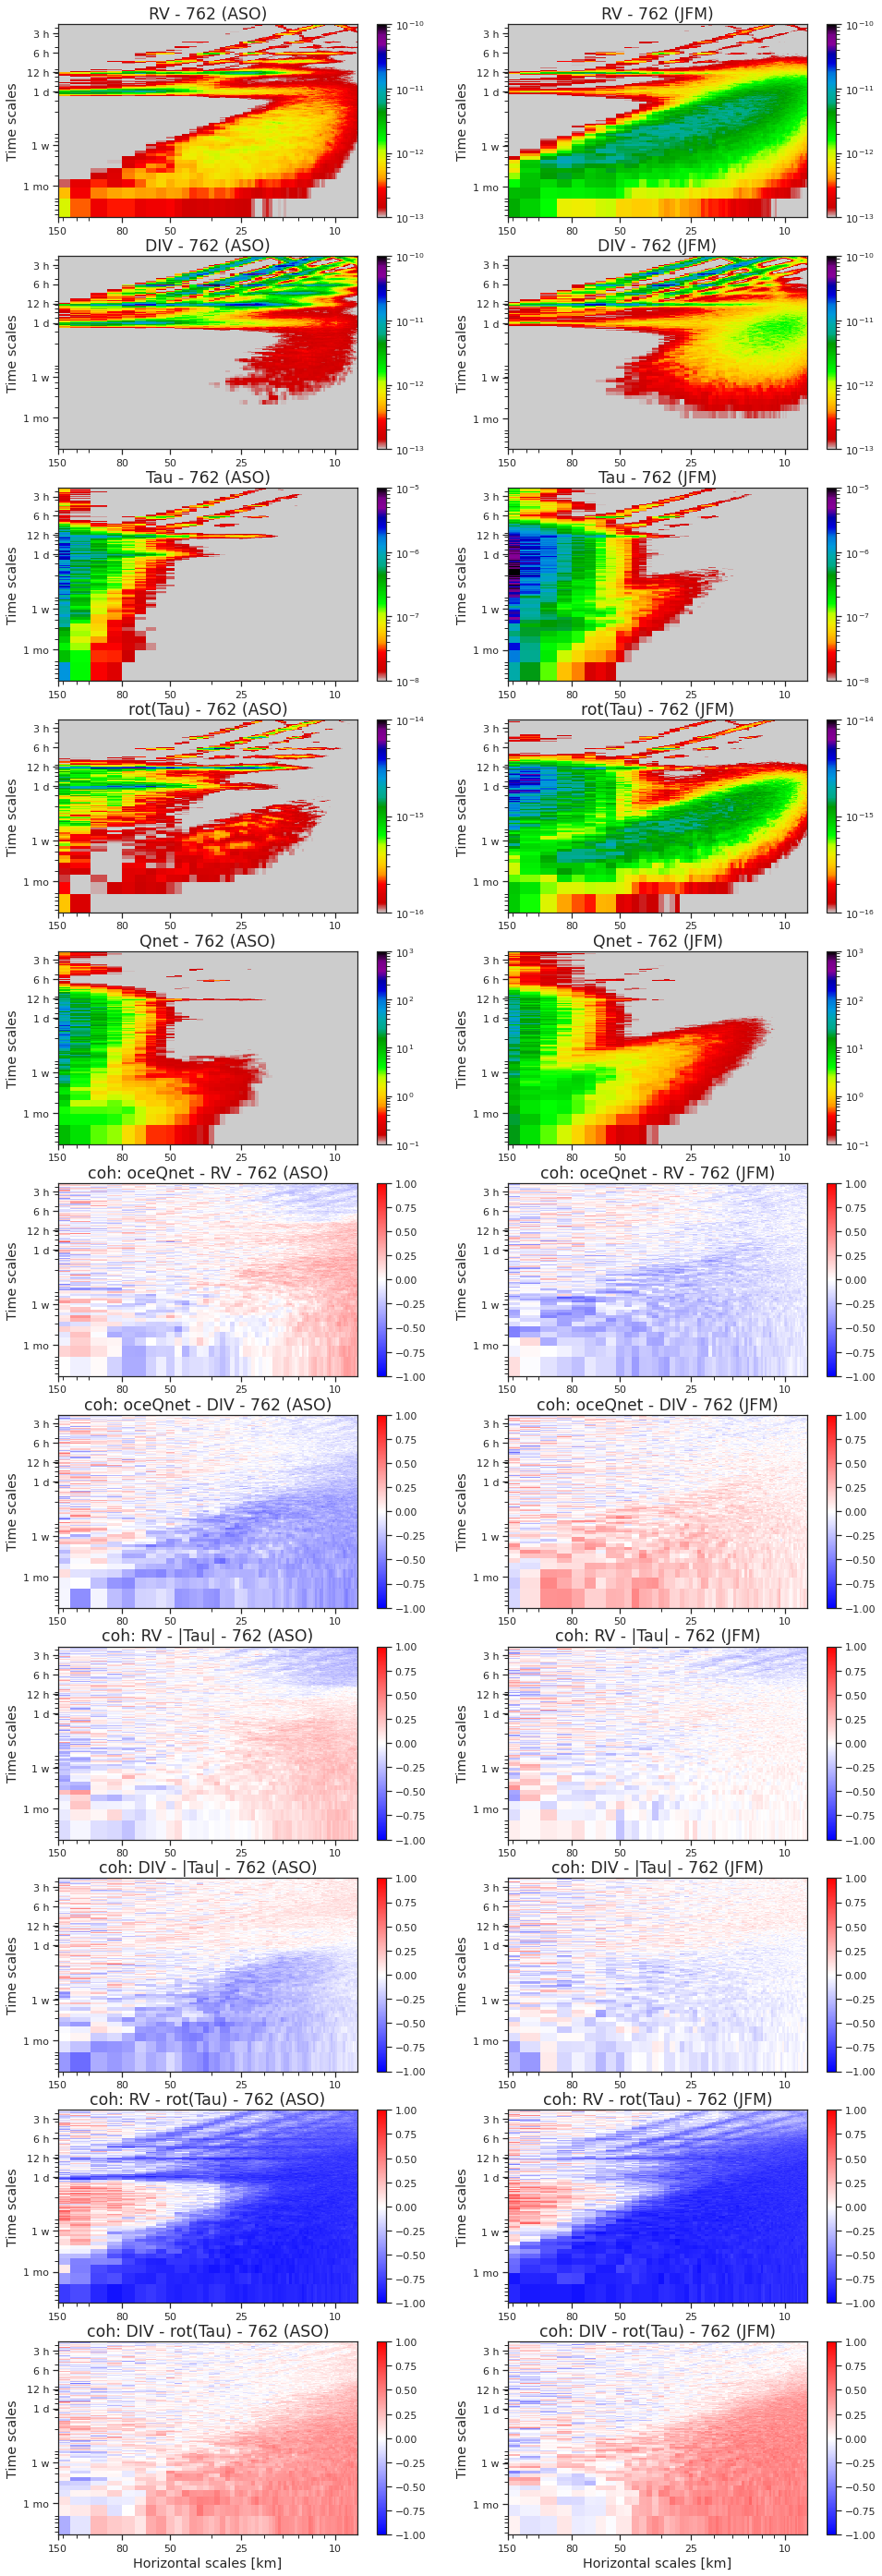

In [18]:
calc_cospectra("California")

2021-04-05 00:38:30 INFO     Plotting: 750 ASO
2021-04-05 00:38:31 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2021-04-05 00:38:31 INFO     Exists? 750: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/750_ASO_hours.npz
2021-04-05 00:38:31 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:38:31 INFO     Spectrum KE already there
2021-04-05 00:38:31 INFO     Spectrum Tau already there
2021-04-05 00:38:31 INFO     Spectrum Tau_norm already there
2021-04-05 00:38:31 INFO     Spectrum Tau_curl already there
2021-04-05 00:38:31 INFO     Spectrum RV already there
2021-04-05 00:38:31 INFO     Spectrum DIV alre

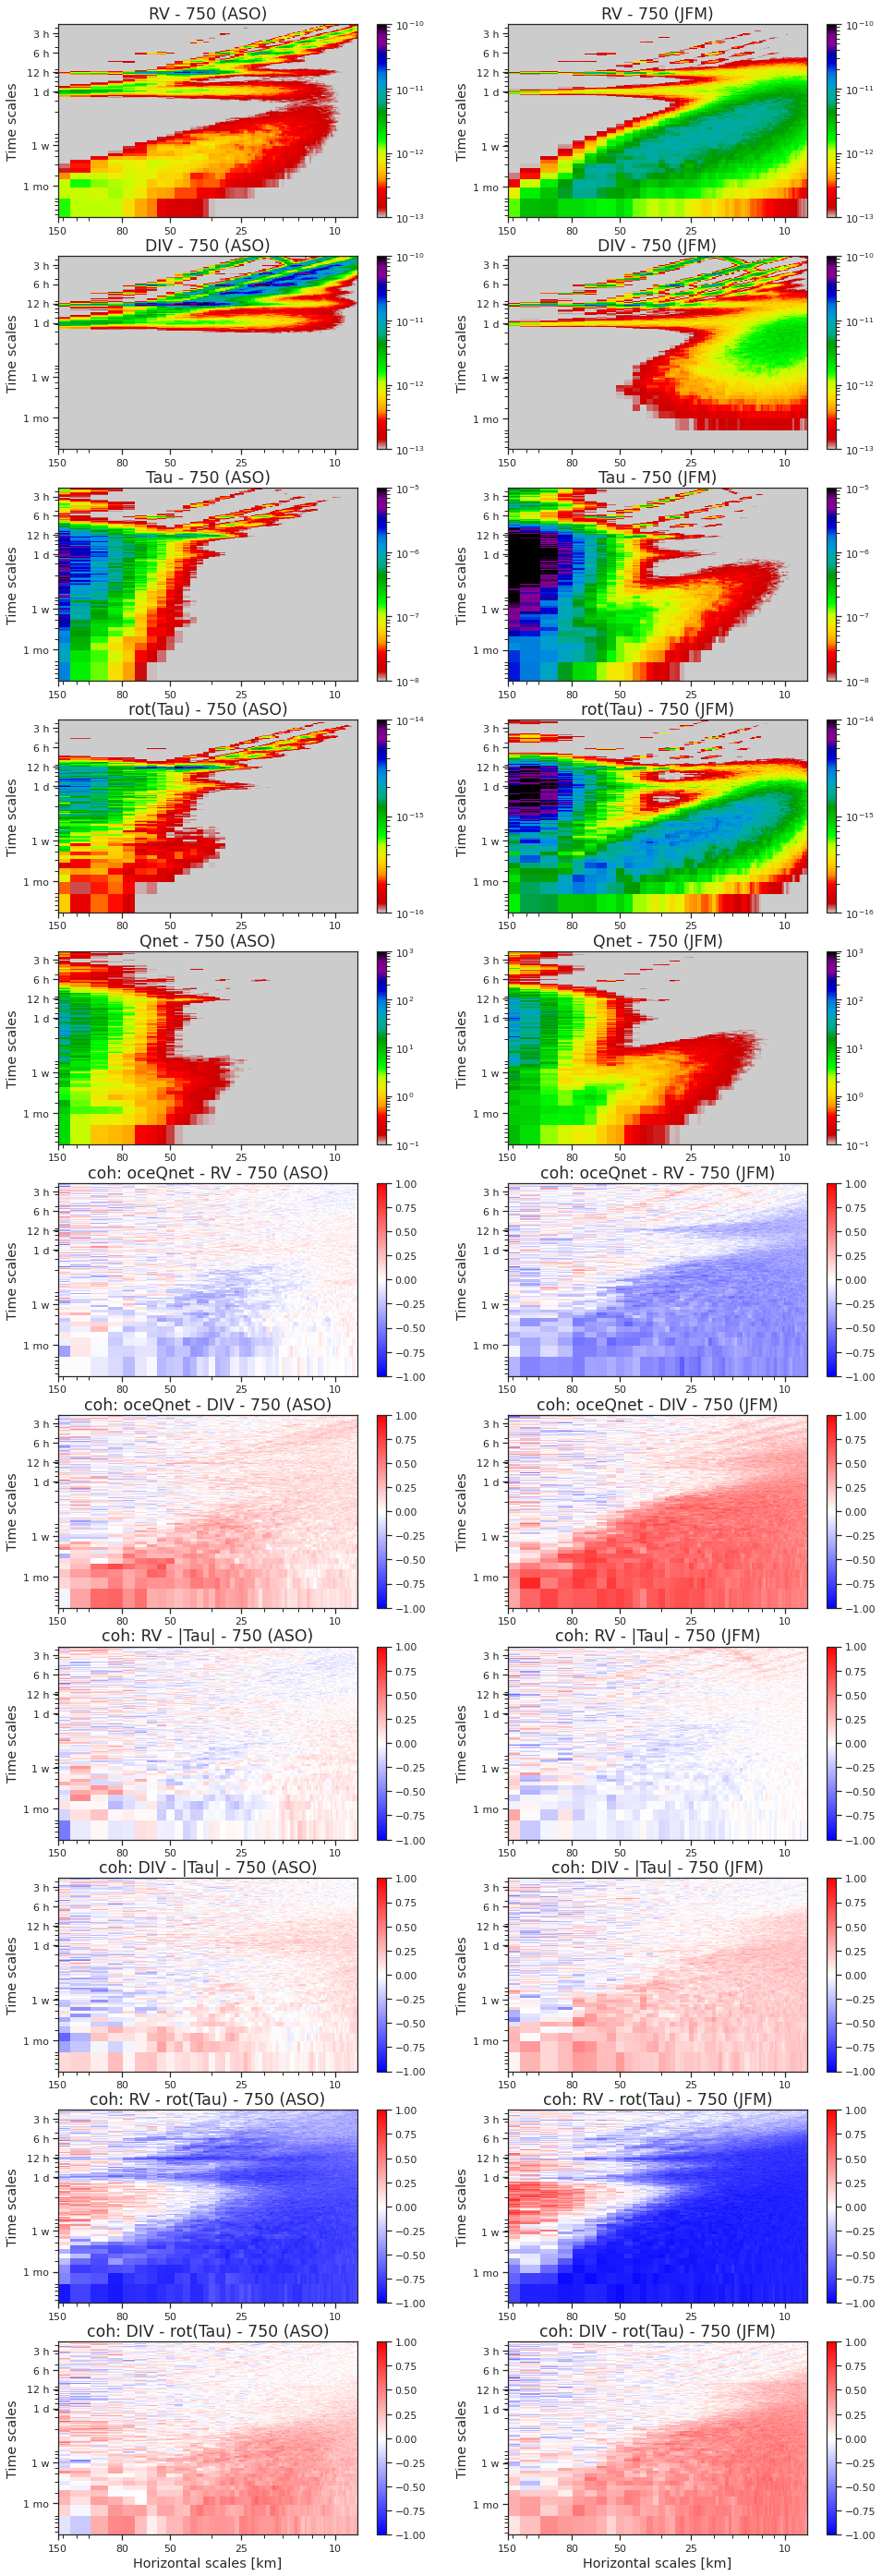

2021-04-05 00:38:51 INFO     Plotting: 730 ASO
2021-04-05 00:38:52 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2021-04-05 00:38:52 INFO     Exists? 730: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/730_ASO_hours.npz
2021-04-05 00:38:52 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']
2021-04-05 00:38:52 INFO     Spectrum KE already there
2021-04-05 00:38:52 INFO     Calculating Tau = FFT_pow(tau_x) + FFT_pow(tau_y)
2021-04-05 00:38:52 WARNING  First load vector into tau -- Vars: dict_keys([])
2021-04-05 00:38:52 INFO     Calculating Tau_norm = FFT_pow(tau_norm)


'LLCRegion' object has no attribute 'load_scalar'


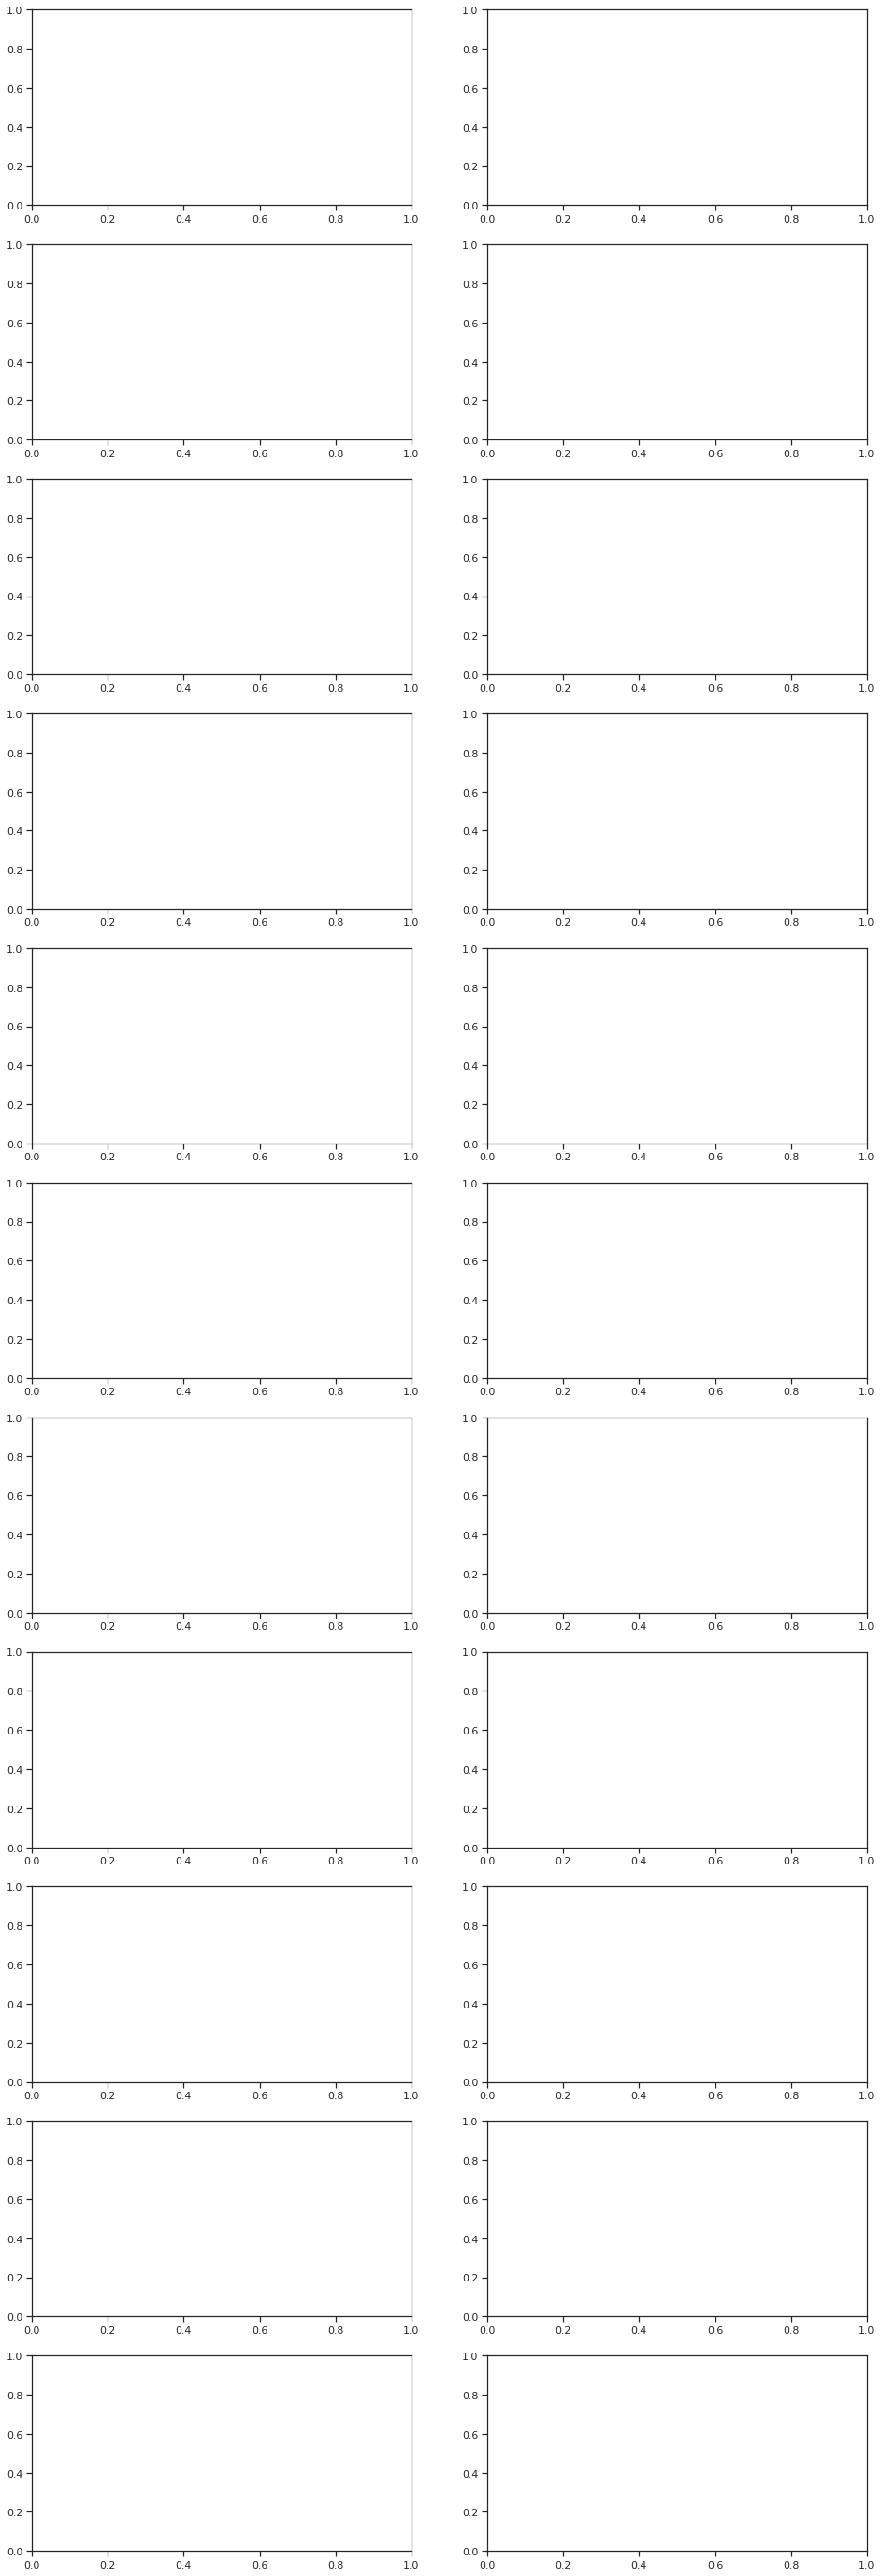

In [19]:
calc_cospectra("Canarias")

2021-04-05 00:39:42 INFO     Plotting: 450 ASO
2021-04-05 00:39:43 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2021-04-05 00:39:43 INFO     Exists? 450: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/450_ASO_hours.npz
2021-04-05 00:39:44 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:39:44 INFO     Spectrum KE already there
2021-04-05 00:39:44 INFO     Spectrum Tau already there
2021-04-05 00:39:44 INFO     Spectrum Tau_norm already there
2021-04-05 00:39:44 INFO     Spectrum Tau_curl already there
2021-04-05 00:39:44 INFO     Spectrum RV already there
2021-04-05 00:39:44 INFO     Spectrum DIV alr

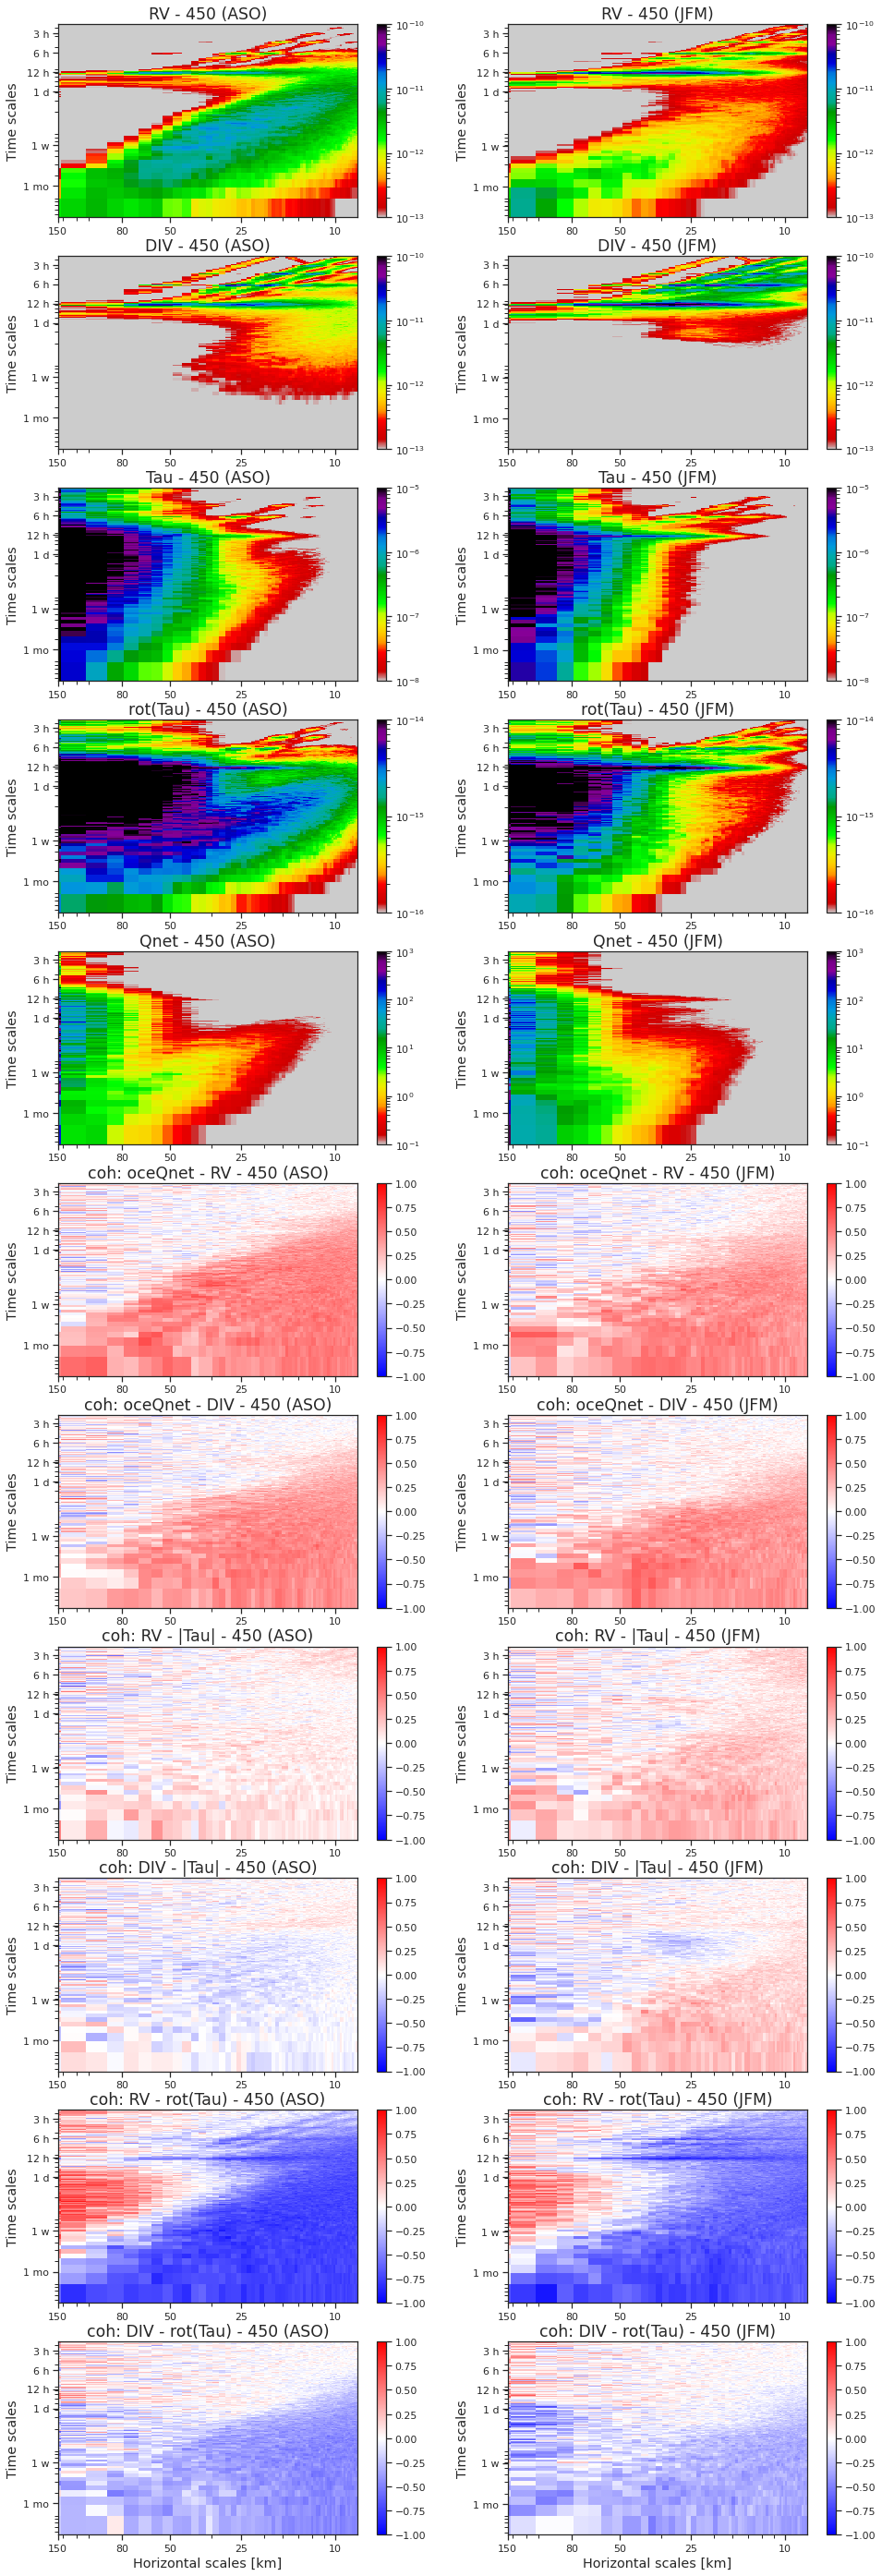

2021-04-05 00:40:02 INFO     Plotting: 572 ASO
2021-04-05 00:40:03 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2021-04-05 00:40:03 INFO     Exists? 572: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/572_ASO_hours.npz
2021-04-05 00:40:04 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:40:04 INFO     Spectrum KE already there
2021-04-05 00:40:04 INFO     Spectrum Tau already there
2021-04-05 00:40:04 INFO     Spectrum Tau_norm already there
2021-04-05 00:40:04 INFO     Spectrum Tau_curl already there
2021-04-05 00:40:04 INFO     Spectrum RV already there
2021-04-05 00:40:04 INFO     Spectrum DIV alre

'Qnet_RV_coh'


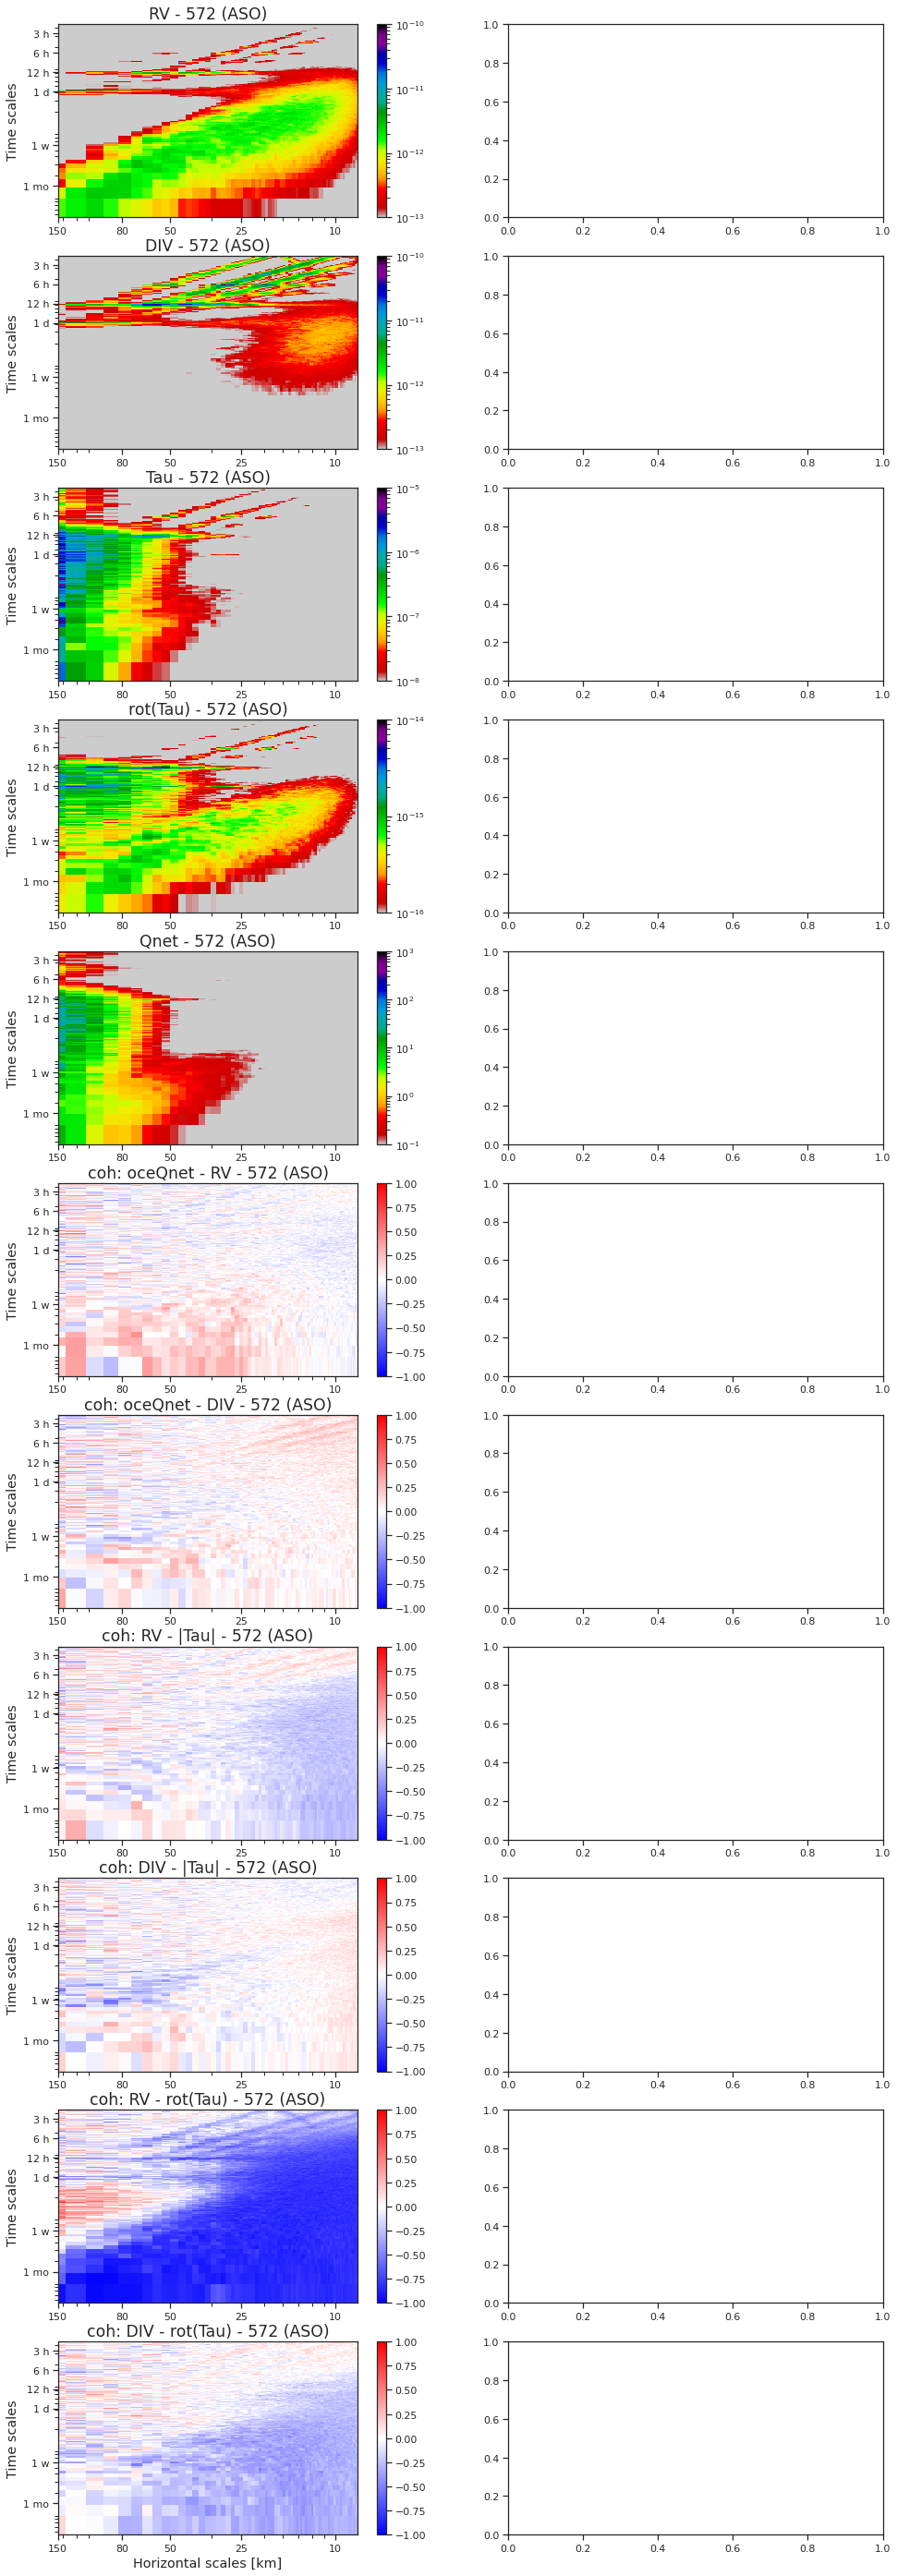

In [20]:
calc_cospectra("Peru")

2021-04-05 00:40:23 INFO     Plotting: 533 ASO
2021-04-05 00:40:24 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2021-04-05 00:40:24 INFO     Exists? 533: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/533_ASO_hours.npz
2021-04-05 00:40:25 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:40:25 INFO     Spectrum KE already there
2021-04-05 00:40:25 INFO     Spectrum Tau already there
2021-04-05 00:40:25 INFO     Spectrum Tau_norm already there
2021-04-05 00:40:25 INFO     Spectrum Tau_curl already there
2021-04-05 00:40:25 INFO     Spectrum RV already there
2021-04-05 00:40:25 INFO     Spectrum DIV alre

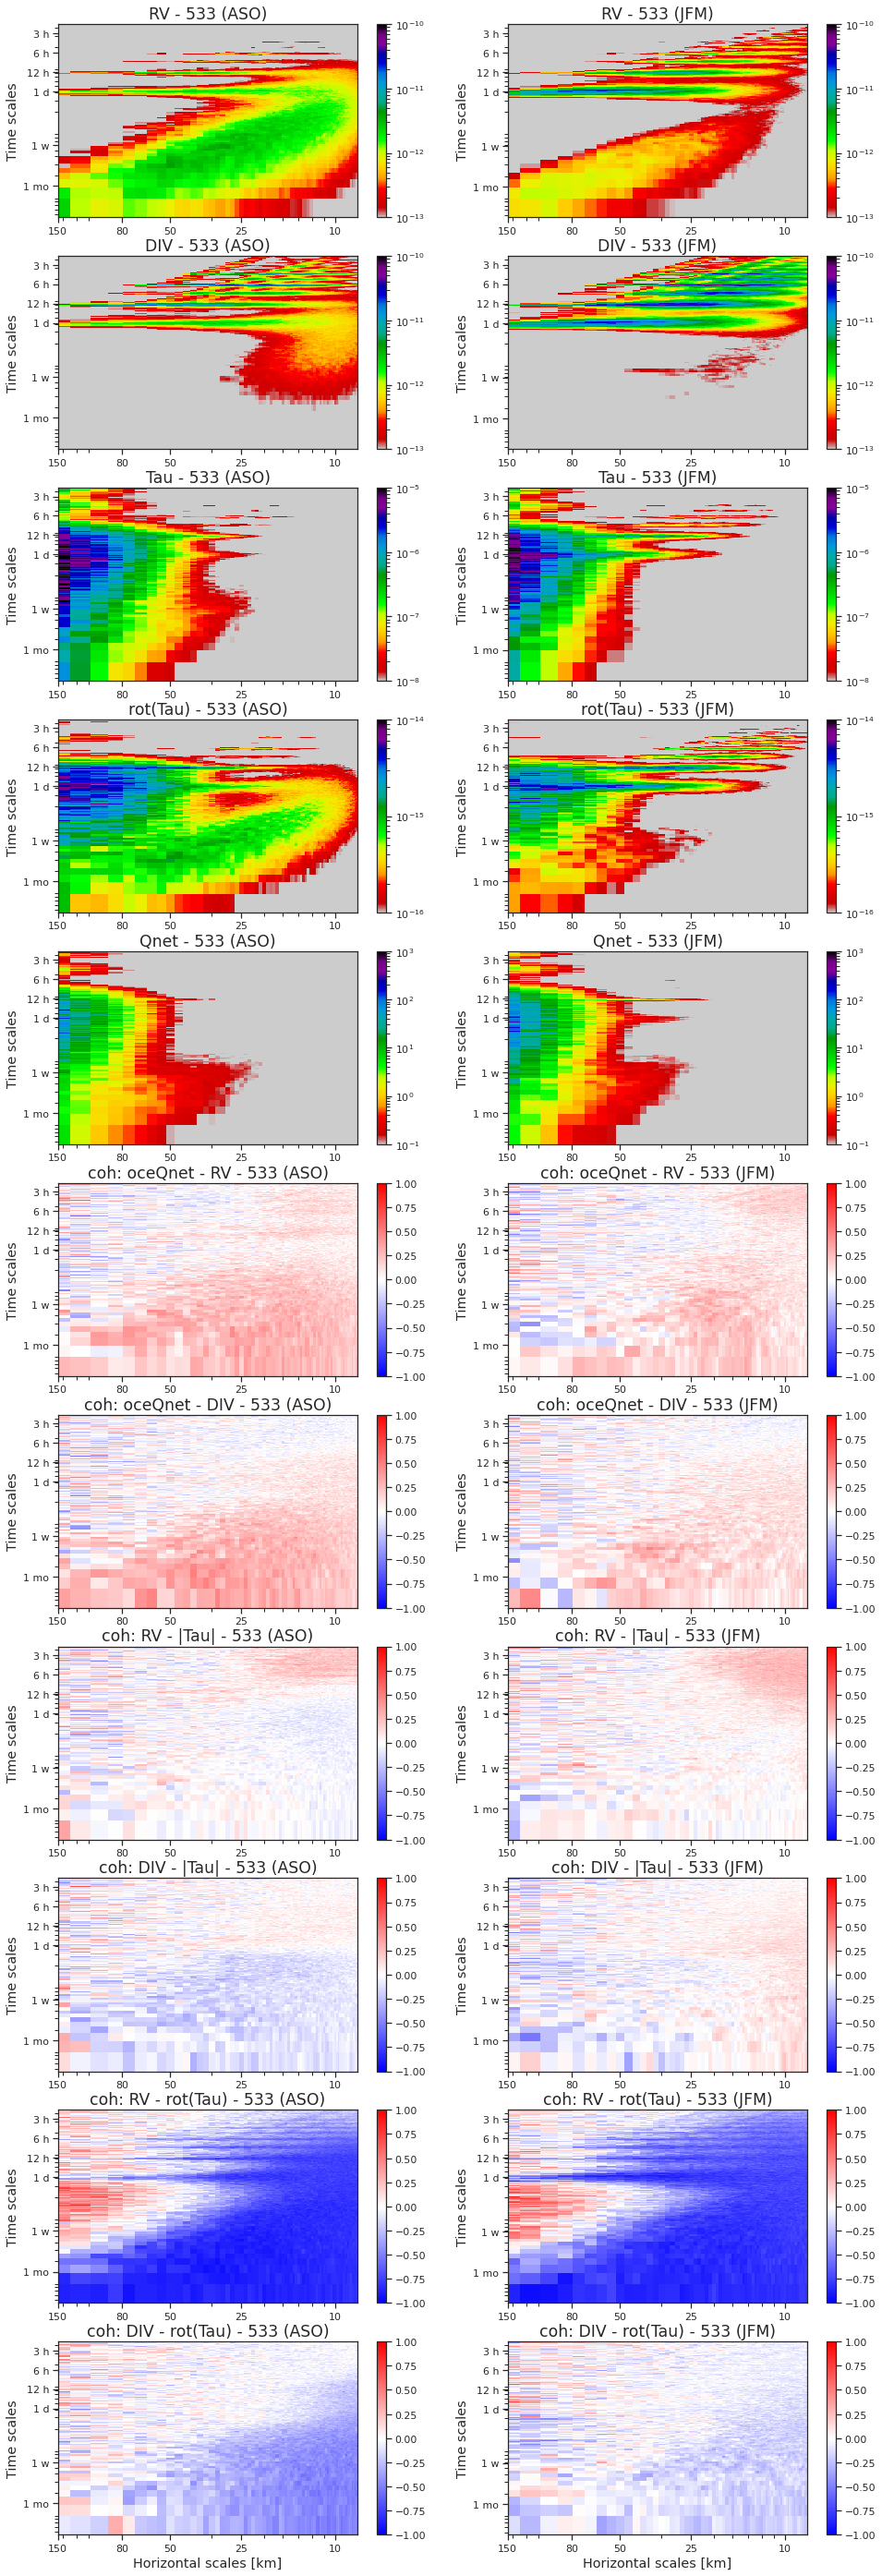

In [21]:
calc_cospectra("Benguela")

2021-04-05 00:42:44 INFO     Plotting: 762 ASO
2021-04-05 00:42:45 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2021-04-05 00:42:45 INFO     Exists? 762: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/762_ASO_hours.npz
2021-04-05 00:42:45 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:42:45 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-04-05 00:42:53 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-04-05 00:43:01 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-04-05 00:43:10 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-04-05 00:43:19 INFO     Loading oceT

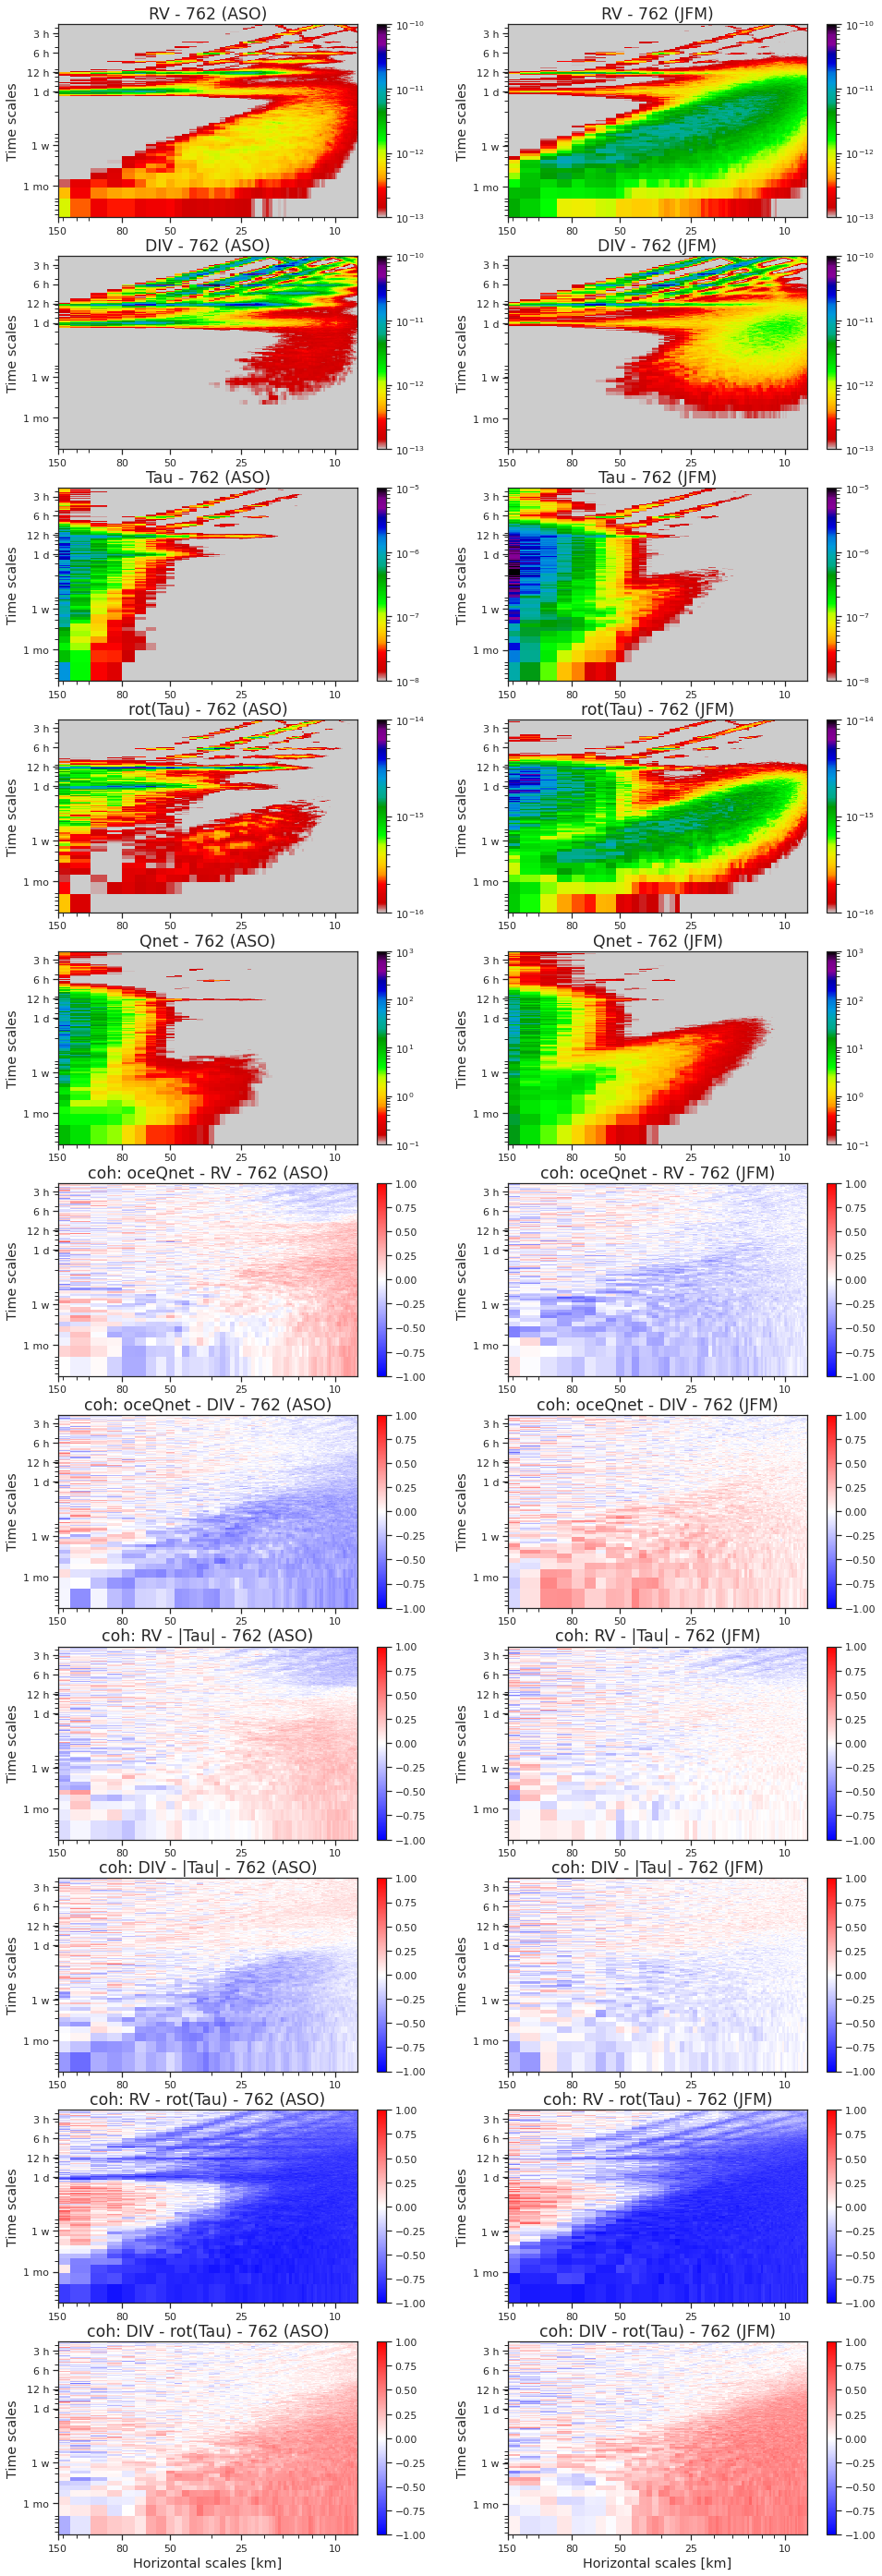

2021-04-05 00:45:47 INFO     Plotting: 750 ASO
2021-04-05 00:45:48 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2021-04-05 00:45:48 INFO     Exists? 750: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/750_ASO_hours.npz
2021-04-05 00:45:49 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:45:49 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-04-05 00:46:31 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-04-05 00:47:11 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-04-05 00:47:52 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-04-05 00:48:33 INFO     Loading oceTA

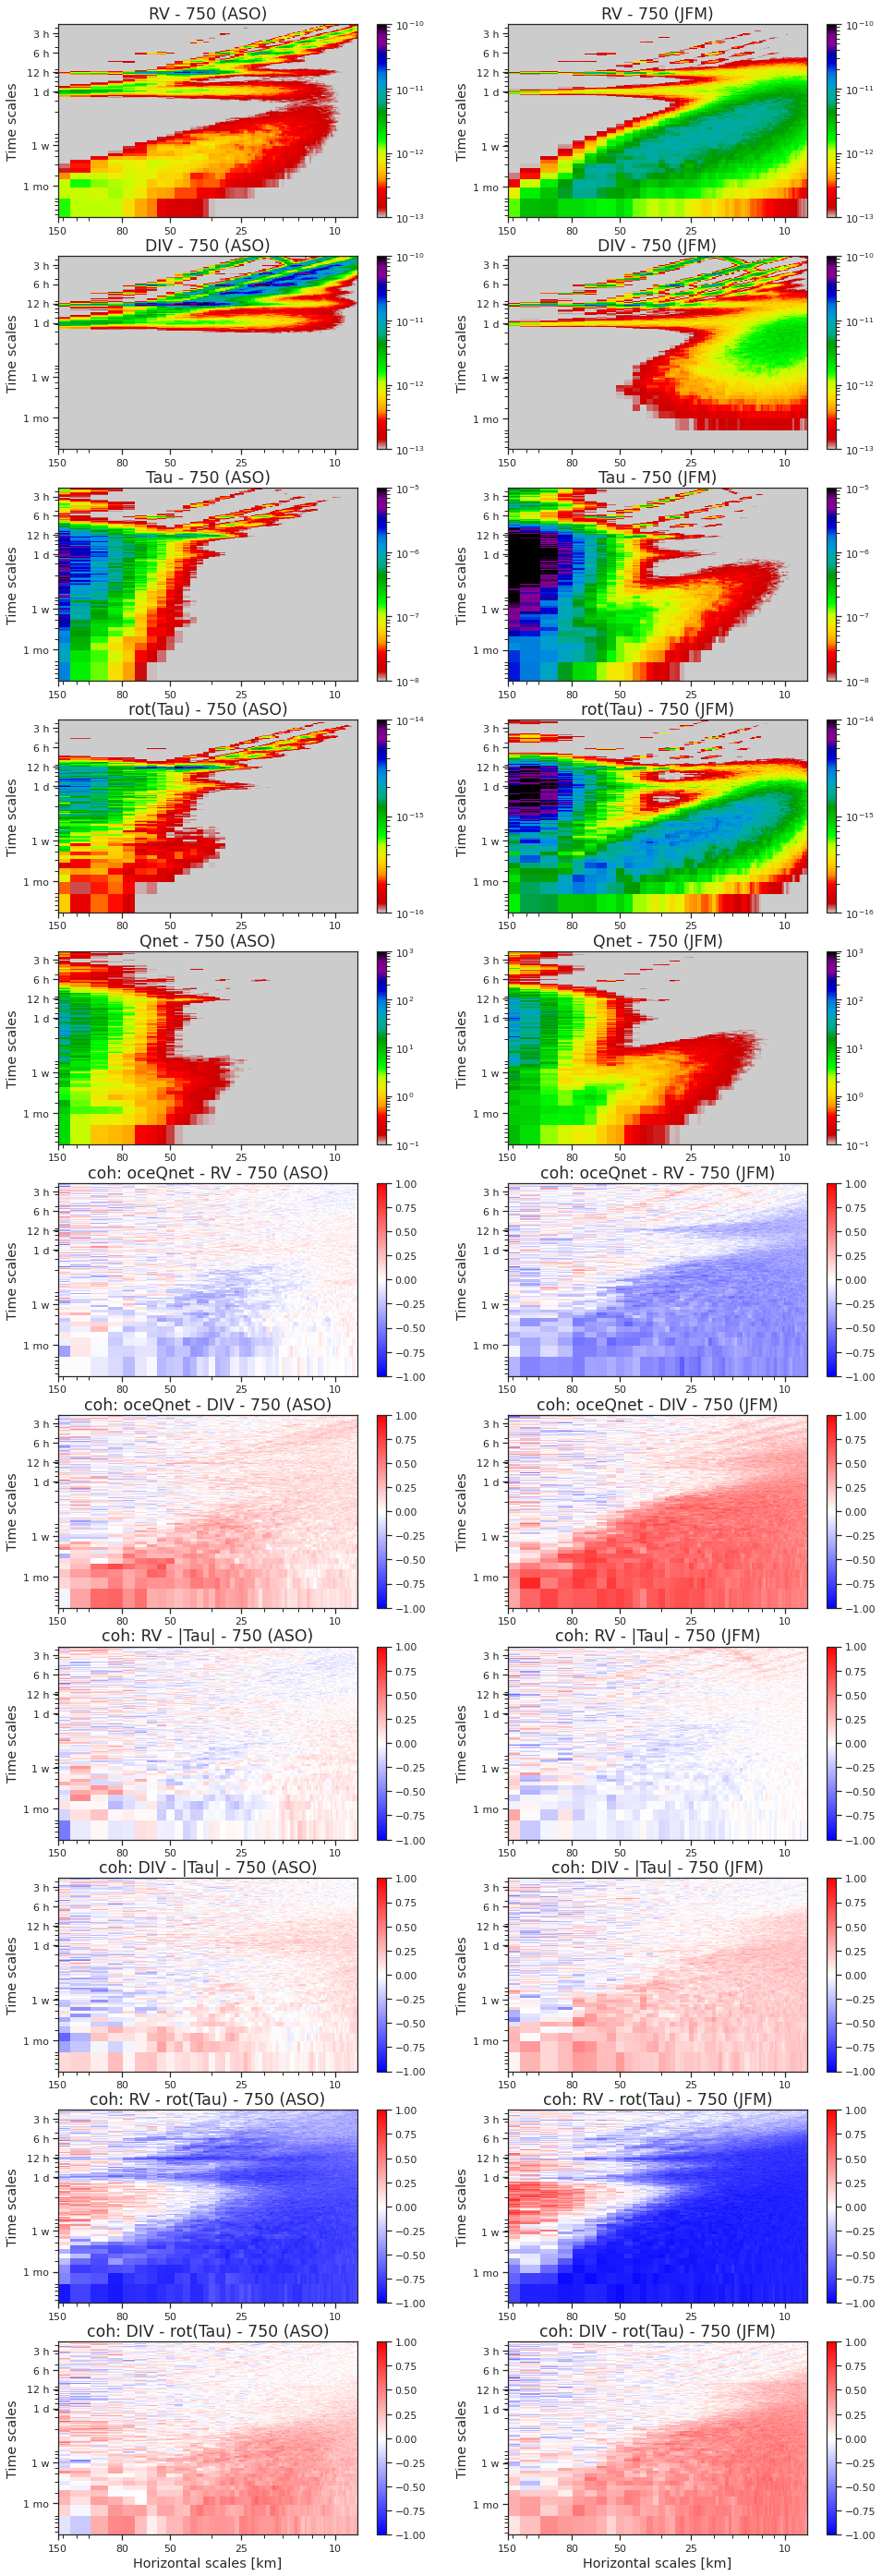

2021-04-05 00:52:36 INFO     Plotting: 572 ASO
2021-04-05 00:52:37 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2021-04-05 00:52:37 INFO     Exists? 572: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/572_ASO_hours.npz
2021-04-05 00:52:38 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-04-05 00:52:38 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2021-04-05 00:53:03 INFO     Loading U: shape (k=0): (290, 289, 2208)
2021-04-05 00:53:41 INFO     Loading V: shape (k=0): (290, 289, 2208)
2021-04-05 00:54:18 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2021-04-05 00:54:59 INFO     Loading oceTA

In [23]:
for rid in [762, 750, 572, 533]:
    try:
        plotRegion(rid)
    except Exception as err:
        print(err)